In [ ]:
!pip install torchaudio transformers datasets jiwer

In [73]:
import os
import re
import torch
import random
from torch.utils.data import Dataset
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer, Wav2Vec2Processor, TrainingArguments, Trainer
from datasets import Dataset, load_metric, Audio, load_from_disk
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import torchaudio
import numpy as np
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

In [3]:
# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [ ]:
# Define paths
BASE_PATH = "YOUR_BASE_PATH" 

AUDIO_DIR = "BASE_PATH\common_voice\cv-valid-train"
CSV_FILE = "BASE_PATH\common_voice\cv-valid-train.csv"

Justication for Tokenizer: 
- wav2vec2-base-960h is pre-trained on a massive dataset of 960 hours of speech data from LibriSpeech. This extensive training provides the model with a strong foundation in understanding the nuances of spoken language, including phoneme and word-level representations.
- Starting with a pre-trained model allows to leverage the power of transfer learning. Fine-tuning the pre-trained model on the specific dataset requires less training data and computational resources compared to training a model from scratch.

Justication for Feature Extractor: 
- The Wav2Vec2 processor wraps a feature extractor and a tokenizer into a single processor, offering all the functionalities both. It takes care of both feature extraction from audio and text label preparation, streamlining the data preprocessing pipeline.

In [5]:
# Load Wav2Vec2 model and tokenizer
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

# Create processor pipeline (Feature extractor built into processor)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

C:\Users\jared\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
C:\Users\jared\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\models\wav2vec2\tokenization_wav2vec2.py:752: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `W

# 1. Data Processing

- cv-valid-train contains almost 200K files (195,776)
- With respect to compute power contraints, random subset of cv-valid-train data is then used, which is then further split into 70-30 train-validation
- Subset was then randomly selected as 20K records (20K/200K = 10%) among dataset, which is justifiably a decent subsample of the dataset  

In [78]:
# Load dataset from CSV
df = pd.read_csv(CSV_FILE)
df

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
195771,cv-valid-train/sample-195771.mp3,the englishman said nothing,1,0,thirties,male,england,NaN
195772,cv-valid-train/sample-195772.mp3,the irish man sipped his tea,1,0,NaN,NaN,NaN,NaN
195773,cv-valid-train/sample-195773.mp3,what do you know about that,1,0,NaN,NaN,NaN,NaN
195774,cv-valid-train/sample-195774.mp3,the phone rang while she was awake,2,0,twenties,male,us,NaN


In [79]:
subset_df = df.sample(20000, replace=False, random_state=42)
subset_df

,filename,text,up_votes,down_votes,age,gender,accent,duration
182715,cv-valid-train/sample-182715.mp3,the fine manufacturing company was a bookkeepe...,2,0,NaN,NaN,NaN,NaN
114956,cv-valid-train/sample-114956.mp3,the mixture took on a reddish color almost the...,1,0,fourties,male,england,NaN
139880,cv-valid-train/sample-139880.mp3,enough said the boy,1,0,NaN,NaN,NaN,NaN
34538,cv-valid-train/sample-034538.mp3,then he sat in the sunfilled doorway smoking t...,2,1,NaN,NaN,NaN,NaN
142907,cv-valid-train/sample-142907.mp3,i've just guaranteed the bank sufficient funds...,1,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
115399,cv-valid-train/sample-115399.mp3,what's she saying now,1,0,NaN,NaN,NaN,NaN
118095,cv-valid-train/sample-118095.mp3,would you like a cappuccino,3,0,NaN,NaN,NaN,NaN
84886,cv-valid-train/sample-084886.mp3,how come you speak spanish he asked,1,0,NaN,NaN,NaN,NaN
135792,cv-valid-train/sample-135792.mp3,it's a man who understands nature and the world,1,0,NaN,NaN,NaN,NaN


In [80]:
listnames = subset_df["filename"]
listnames

182715    cv-valid-train/sample-182715.mp3
114956    cv-valid-train/sample-114956.mp3
139880    cv-valid-train/sample-139880.mp3
34538     cv-valid-train/sample-034538.mp3
142907    cv-valid-train/sample-142907.mp3
                        ...               
115399    cv-valid-train/sample-115399.mp3
118095    cv-valid-train/sample-118095.mp3
84886     cv-valid-train/sample-084886.mp3
135792    cv-valid-train/sample-135792.mp3
39598     cv-valid-train/sample-039598.mp3
Name: filename, Length: 20000, dtype: object

In [ ]:
# Create an empty dataframe
df = pd.DataFrame() 
df["filename"] = subset_df["filename"]
df["text"] = subset_df["text"]
df

,filename,text
182715,cv-valid-train/sample-182715.mp3,the fine manufacturing company was a bookkeepe...
114956,cv-valid-train/sample-114956.mp3,the mixture took on a reddish color almost the...
139880,cv-valid-train/sample-139880.mp3,enough said the boy
34538,cv-valid-train/sample-034538.mp3,then he sat in the sunfilled doorway smoking t...
142907,cv-valid-train/sample-142907.mp3,i've just guaranteed the bank sufficient funds...
...,...,...
115399,cv-valid-train/sample-115399.mp3,what's she saying now
118095,cv-valid-train/sample-118095.mp3,would you like a cappuccino
84886,cv-valid-train/sample-084886.mp3,how come you speak spanish he asked
135792,cv-valid-train/sample-135792.mp3,it's a man who understands nature and the world


Justification for Preprocessing:
- Resampling to Consistent Rate: The Wav2Vec2ForCTC model expects input audio with a specific sampling rate (e.g., 16000 Hz).Inconsistent sampling rates can degrade model performance. Resampling ensures uniform input to the model, leading to more stable and accurate training.

In [82]:
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def preprocess_audio(audio_dir, filename):    
    print(audio_dir)
    print(filename)
    full_path = os.path.join(audio_dir, filename) 
    print(f"Loading audio from: {full_path}")  # Print the full path
    try:
        audio, sample_rate = librosa.load(full_path, sr=16000) 
        print(audio)
        print(sample_rate)
        
        # Checking if resampling if necessary
        if sample_rate != 16000:
            audio = librosa.resample(audio, orig_sr=sample_rate, target_sr=16000) 
        
    except Exception as e:
        print("Failed to transcribe audio" + str(e))

    return audio

def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).upper()
    return batch

def prepare_dataset(batch):
    audio = batch["audio"]
    batch["input_values"] = processor(audio, sampling_rate=16000).input_values[0]
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

In [ ]:
df['audio'] = df['filename'].map(lambda x: preprocess_audio(AUDIO_DIR, x))
df

In [ ]:
# Convert the pandas DataFrame to a Hugging Face Dataset
dataset = Dataset.from_pandas(df) 
dataset = dataset.map(remove_special_characters)
dataset = dataset.map(prepare_dataset) 

In [ ]:
# applying train-test split of 70-30 to split train-val sets
dataset = dataset.train_test_split(test_size=0.3, seed=42)

Storing dataset to disk then loading from there as a progress checkpoint, since earlier code took a long time to run. 

In [18]:
dataset.save_to_disk("dataset_new") 

Saving the dataset (0/17 shards):   0%|          | 0/14000 [00:00<?, ? examples/s]

Saving the dataset (0/7 shards):   0%|          | 0/6000 [00:00<?, ? examples/s]

# 2. Model Development

In [6]:
dataset = load_from_disk("dataset_new") 

dataset

DatasetDict({
    train: Dataset({
        features: ['filename', 'text', 'audio', '__index_level_0__', 'input_values', 'labels'],
        num_rows: 14000
    })
    test: Dataset({
        features: ['filename', 'text', 'audio', '__index_level_0__', 'input_values', 'labels'],
        num_rows: 6000
    })
})

Custom data collator is beneficial in some situations, like towards Advanced Padding Strategies if more control over padding is needed. In this situation, the replacement padding is done with -100 to ignore loss correctly.

In [7]:
@dataclass
class DataCollatorCTCWithPadding:

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # Replacing padding with -100 so as to correctly ignore loss 
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [8]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [9]:
total_params = 0

for name, param in model.named_parameters():
    print(f"Layer: {name} | Shape: {param.shape}") 
    total_params += torch.prod(torch.tensor(param.shape)).item() 

print(f"Total number of parameters: {total_params}")
print(f"Model size (approximately): {total_params * 4 / (1024 * 1024):.2f} MB") 

Layer: wav2vec2.masked_spec_embed | Shape: torch.Size([768])
Layer: wav2vec2.feature_extractor.conv_layers.0.conv.weight | Shape: torch.Size([512, 1, 10])
Layer: wav2vec2.feature_extractor.conv_layers.0.layer_norm.weight | Shape: torch.Size([512])
Layer: wav2vec2.feature_extractor.conv_layers.0.layer_norm.bias | Shape: torch.Size([512])
Layer: wav2vec2.feature_extractor.conv_layers.1.conv.weight | Shape: torch.Size([512, 512, 3])
Layer: wav2vec2.feature_extractor.conv_layers.2.conv.weight | Shape: torch.Size([512, 512, 3])
Layer: wav2vec2.feature_extractor.conv_layers.3.conv.weight | Shape: torch.Size([512, 512, 3])
Layer: wav2vec2.feature_extractor.conv_layers.4.conv.weight | Shape: torch.Size([512, 512, 3])
Layer: wav2vec2.feature_extractor.conv_layers.5.conv.weight | Shape: torch.Size([512, 512, 2])
Layer: wav2vec2.feature_extractor.conv_layers.6.conv.weight | Shape: torch.Size([512, 512, 2])
Layer: wav2vec2.feature_projection.layer_norm.weight | Shape: torch.Size([512])
Layer: wav2

In [10]:
model

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

Model Development Rationale:
1. Freezing feature extractor: Unfreezing it to fine-tune the entire model for potentially better performance effectively is "fine-tuning from scratch". However, freezing the feature extractor is a common and effective strategy for fine-tuning pre-trained models like Wav2Vec2. It allows for faster training, improved stability, and better generalization, especially when dealing with limited training data. Notably, freezing the feature extractor effectively leverages transfer learning. The model benefits from the pre-trained knowledge of the feature extractor, allowing it to learn the specific task (e.g., speech recognition) more quickly and effectively.

In [11]:
model.freeze_feature_extractor()

C:\Users\jared\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\models\wav2vec2\modeling_wav2vec2.py:1635: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5.Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


In [12]:
# Initialize counters
unfrozen_params = 0
frozen_params = 0

# Check which parameters are modified and are unfreezed
for name, param in model.named_parameters():
    if param.requires_grad:
        unfrozen_params += torch.prod(torch.tensor(param.shape)).item() 
    else:
        frozen_params += torch.prod(torch.tensor(param.shape)).item()

total_params = frozen_params + unfrozen_params
frozen_params_percentage = (frozen_params / total_params) * 100
unfrozen_params_percentage = (unfrozen_params / total_params) * 100

print(f"Total number of parameters: {total_params}")
print(f"Number of frozen parameters: {frozen_params} ({frozen_params_percentage:.2f}%)")
print(f"Number of unfrozen parameters: {unfrozen_params} ({unfrozen_params_percentage:.2f}%)") 

Total number of parameters: 94396320
Number of frozen parameters: 4200448 (4.45%)
Number of unfrozen parameters: 90195872 (95.55%)


WER is a widely accepted and standardized metric in the speech recognition field. This allows for consistent comparison of different ASR systems and research findings across the community. 
WER quantifies the number of errors made by the ASR system in transcribing speech. It also directly reflects how well the system aligns with human speech.
As such, we use WER as the desired metric for this task.

In [13]:
wer_metric = load_metric("wer")

C:\Users\jared\AppData\Local\Temp\ipykernel_10332\24688115.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")


In [14]:
def compute_metrics(pred):
  pred_logits = pred.predictions
  pred_ids = np.argmax(pred_logits, axis=-1)
  # Padding replacement with -100 so as to correctly compute metrics
  pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

  # Decode predictions and references
  pred_str = processor.batch_decode(pred_ids)
  label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

  # Calculate WER as metric 
  wer = wer_metric.compute(predictions=pred_str, references=label_str)

  return {"wer": wer}

Hyperparameters Rationale:
- Batch size: Since batch sizes are commonly exponents of 2, knowing that the dataset for training has been sub-sampled to 2K with 70-30 split, a batch size of 32 is then selected as it allows for sufficient training across the provided training data.
- Learning rate: 1e-4 is a common starting learning rate for fine-tuning pre-trained language models. However, knowing that the model has already been pre-trained on a large dataset and the aim is to fine-tune towards a custom dataset, the learning rate is thereby reduced slightly to 1e-5.
- Max steps: It allows control over the training time and computational resources more effectively; by defining a fixed number of training steps, it is more convenient and reliable than relying solely on the number of epochs. max_steps of 100 is then selected as a balance of sufficient model training plus time efficiency given limited computational resources.

Note: GPU functions (eg, fp16=True) have been omitted for this assessment as local device used does not support CUDA :( 

In [15]:
training_args = TrainingArguments(
    output_dir="./results", 
    num_train_epochs=1,
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=32,  
    max_steps=100,
    save_steps=100,
    eval_steps=100,
    logging_steps=50,
    learning_rate=1e-5,
    warmup_steps=100, 
    report_to=["tensorboard"]
)

In [16]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=processor.feature_extractor,
)

max_steps is given, it will override any value given in num_train_epochs


In [17]:
# trainer.train()

Clarification: By right this is the procedure to fine-tune an ASR model ideally with GPUs, but the above trainer is taking 6-7H per epoch on local device.

Due to computing limitations, the following revisions are made:
- Batch sizes reduced to 8 (Original Batch size of 32 leads to one epoch being ~1H, for numerous epochs this would take a while)
- Randomly sub-sample K from validation set of 600 records; arguably this is bad practice due to risks of data leakage and overfitting, however in interests of resource constraints, K records are randomly selected to form the validation set as to observe metrics during model training; K=32 was eventually selected   

In [18]:
training_args_v2 = TrainingArguments(
    output_dir="./results", 
    num_train_epochs=1,
    per_device_train_batch_size=8,  # reduced from 32 
    per_device_eval_batch_size=8,  # reduced from 32
    evaluation_strategy="steps",
    max_steps=100,
    save_steps=20,
    eval_steps=20,
    logging_steps=20,
    learning_rate=1e-5,
    report_to=["tensorboard"]
)

PyTorch: setting up devices


In [19]:
# Define the number of samples for each evaluation subset
num_eval_samples = 32 
eval_results = []

# Randomly select indices for the evaluation subset
for i in range(num_eval_samples):
    random_indices = random.sample(range(len(dataset["test"])), num_eval_samples) 
    val_subset = dataset["test"].select(random_indices) 

val_subset

Dataset({
    features: ['filename', 'text', 'audio', '__index_level_0__', 'input_values', 'labels'],
    num_rows: 32
})

In [20]:
trainer_v2 = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args_v2,
    compute_metrics=compute_metrics,
    train_dataset=dataset["train"],
    eval_dataset=val_subset,    # replced from dataset["test"]
    tokenizer=processor.feature_extractor,
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer_v2.train()

# 3. Results

In [33]:
loss_df = pd.DataFrame(trainer_v2.state.log_history)

loss_df

,loss,learning_rate,epoch,step,eval_loss,eval_wer,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,263.0024,0.000008,0.01,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.01,20,183.492935,0.150307,30.8891,1.036,0.129,NaN,NaN,NaN,NaN,NaN
2,209.1323,0.000006,0.02,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.02,40,177.363770,0.144172,31.9061,1.003,0.125,NaN,NaN,NaN,NaN,NaN
4,195.1968,0.000004,0.03,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,0.03,60,167.607376,0.138037,31.3244,1.022,0.128,NaN,NaN,NaN,NaN,NaN
6,224.9356,0.000002,0.05,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,0.05,80,165.750168,0.134969,30.9215,1.035,0.129,NaN,NaN,NaN,NaN,NaN
8,216.0207,0.000000,0.06,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,0.06,100,162.698532,0.134969,30.6834,1.043,0.130,NaN,NaN,NaN,NaN,NaN


In [34]:
train_loss_df = loss_df.dropna(axis=0, subset="loss")
train_loss_df

,loss,learning_rate,epoch,step,eval_loss,eval_wer,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,263.0024,0.000008,0.01,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,209.1323,0.000006,0.02,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,195.1968,0.000004,0.03,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,224.9356,0.000002,0.05,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,216.0207,0.000000,0.06,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
eval_loss_df = loss_df.dropna(axis=0, subset="eval_loss")
eval_loss_df

,loss,learning_rate,epoch,step,eval_loss,eval_wer,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
1,NaN,NaN,0.01,20,183.492935,0.150307,30.8891,1.036,0.129,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.02,40,177.363770,0.144172,31.9061,1.003,0.125,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,0.03,60,167.607376,0.138037,31.3244,1.022,0.128,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,0.05,80,165.750168,0.134969,30.9215,1.035,0.129,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,0.06,100,162.698532,0.134969,30.6834,1.043,0.130,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'Loss')

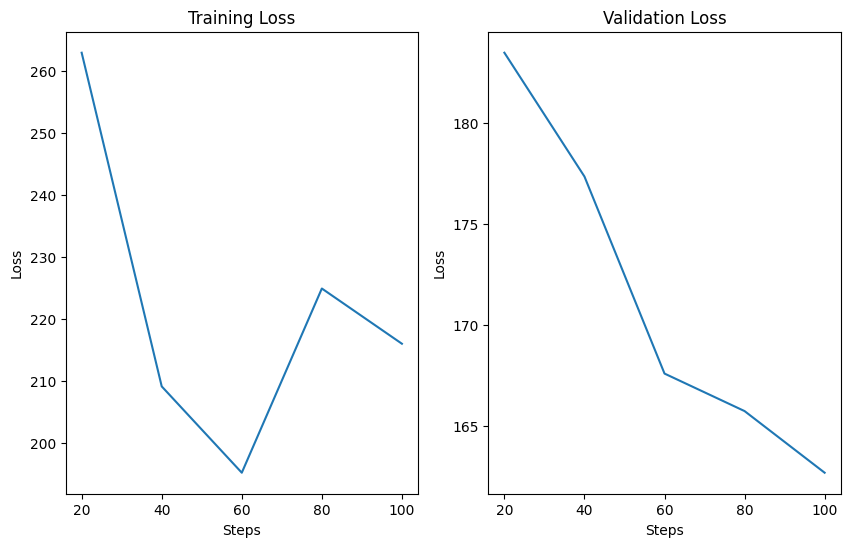

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(10,6))

axs[0].plot(train_loss_df["step"], train_loss_df["loss"])
axs[0].set_title("Training Loss")
axs[0].set_xlabel('Steps')
axs[0].set_ylabel('Loss')

axs[1].plot(eval_loss_df["step"], eval_loss_df["eval_loss"])
axs[1].set_title("Validation Loss")
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('Loss')

Interpretation of Results:
- Validation loss OK, with loss decreasing over time
- Training loss generally decreasing, but could be better with slight increase then decrease over the halfway mark
- Do note training procedure was modified compared to original intentions due to computational resource limitations
- Ideally in expected model training, training and validation loss should converge over a long time  

In [ ]:
# saving the model
FT_ASR_MODEL = 'wav2vec2-large-960h-cv'
trainer_v2.save_model(FT_ASR_MODEL)